### Imports

In [1]:
!pip install tensorflow_text
!pip install bokeh
!pip install simpleneighbors[annoy]
!pip install tqdm

     |████████████████████████████████| 3.4MB 7.0MB/s 
     |████████████████████████████████| 655kB 5.2MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp36-cp36m-linux_x86_64.whl size=390344 sha256=ff590aef677756a5a882b6a2d77e93b102adcdd82e0c98defea2c88e341831dd
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


In [92]:
import bokeh
import bokeh.models
import bokeh.plotting
import numpy as np
import os
import random as r
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow as tf1
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer
from simpleneighbors import SimpleNeighbors
from tqdm import tqdm
from tqdm import trange
import xml.etree.ElementTree as ET
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' 

model = hub.load(module_url)

def embed_text(input):
  return model(input).numpy()

In [4]:
lang_list = ['de','en','es','fr','it','nl','pl','pt']

### Load titles

In [5]:
language_to_sentences = {}
language_to_news_path = {}

for language_code in lang_list: 

  base_path = '/content/drive/MyDrive/corpus/title.'
  news_path = base_path + language_code
  language_to_sentences[language_code] = pd.read_csv(news_path, sep='\t', header=None)[0]
  language_to_news_path[language_code] = news_path

  print('{:,} {} sentences'.format(len(language_to_sentences[language_code]), language_code))

98 de sentences
98 en sentences
96 es sentences
98 fr sentences
99 it sentences
98 nl sentences
101 pl sentences
96 pt sentences


In [ ]:
language_to_sentences

{'de': 0                                                 title
 1     'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...
 2     'EWG Rat: Verordnung Nr. 1 zur Regelung der Sp...
 3     'Entscheidung über die Gründung des "Amtsblatt...
 4     'EAG Rat: Satzung der Euratom-Versorgungsagentur'
                             ...                        
 93    'Richtlinie 70/222/EWG des Rates vom 20. März ...
 94    'Verordnung (EWG) Nr. 538/70 der Kommission vo...
 95    'Richtlinie 70/388/EWG des Rates vom 27. Juli ...
 96    'Richtlinie 70/50/EWG der Kommission vom 22. D...
 97    'Verordnung (EWG) Nr. 1467/70 des Rates vom 20...
 Name: 0, Length: 98, dtype: object,
 'en': 0                                                 title
 1     "Decision creating the 'Official Journal of th...
 2     'EAEC Council: The Statutes of the Euratom Sup...
 3     'EEC Council: Regulation No 1 determining the ...
 4     'EAEC Council: Regulation No 3 implementing Ar...
                             ...       

###Load texts

In [6]:
language_to_sentences_text = {}
language_to_news_path_text = {}

for language_code in lang_list: 

  base_path = '/content/drive/MyDrive/corpus/text.'
  news_path = base_path + language_code
  language_to_sentences_text[language_code] = pd.read_csv(news_path, sep='\t', header=None)[0]
  language_to_news_path_text[language_code] = news_path

  print('{:,} {} texts'.format(len(language_to_sentences_text[language_code]), language_code))

1,001 de texts
1,001 en texts
1,001 es texts
1,001 fr texts
1,001 it texts
1,001 nl texts
1,001 pl texts
1,001 pt texts


In [ ]:
language_to_sentences_text

{'de': 0                                                    text
 1                     von dem es seine Rechte herleitet.'
 2                           insbesondere auf Artikel 43,'
 3                             von Einzelbetrieben stammen
 4                                      'S : 37-65-71-103'
                               ...                        
 996     so daß sich ihre Koordinierung gegenüber allen...
 997     daß sie eine beherrschende Stellung auf dem ge...
 998     '(1) Es wird ein Verwaltungsausschuß für leben...
 999     soll ab 1. November 1962 für Rindfleisch angew...
 1000                    hier der Handel mit Frischfleisch
 Name: 0, Length: 1001, dtype: object,
 'en': 0                                                    text
 1       '(m) %quot%compulsorily notifiable diseases%qu...
 2       '1. Officially supervised tuberculin tests mus...
 3       in order to ensure certainty in the law as reg...
 4       i.e. they must contain 100 000 international u...
     

### Create text files for each language

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/corpus/data.csv')

In [ ]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,language,title,text
0,de,"['JRC-ACQUIS 31958R0003(01) German', 'EAG Rat:...",['VERORDNUNG Nr. 3 zur Anwendung des Artikels ...
1,de,"['JRC-ACQUIS 31958R0001 German', 'EWG Rat: Ver...",['EUROPÄISCHE WIRTSCHAFTSGEMEINSCHAFT DER RAT ...
2,de,"['JRC-ACQUIS 31958D1006(02) German', 'Entschei...",['ENTSCHEIDUNG über die Gründung des %quot%Amt...
3,de,"['JRC-ACQUIS 31958Q1101 German', 'EAG Rat: Sat...","['SATZUNG DER EURATOM-VERSORGUNGSAGENTUR', 'DE..."
4,de,"['JRC-ACQUIS 31958D1006(01) German', 'ENTSCHEI...",['ENTSCHEIDUNG über die Gründung des Amtsblatt...


In [ ]:
df.tail()

,language,title,text
188257,pt,"['JRC-ACQUIS C2006/154/49 Portuguese', 'Proces...",['Acção intentada em 28 de Abril de 2006 — Hel...
188258,pt,"['JRC-ACQUIS C2006/178/80 Portuguese', 'Proces...",['Recurso interposto em 16 de Junho de 2006 — ...
188259,pt,"['JRC-ACQUIS C2006/011/05 Portuguese', 'Não op...","['Não oposição a uma concentração notificada',..."
188260,pt,"['JRC-ACQUIS C2006/108/06 Portuguese', 'Proces...",['Recurso interposto em 15 de Fevereiro de 200...
188261,pt,['JRC-ACQUIS 52006PC0472 Portuguese'],"['PT', 'Bruxelas, 30.8.2006', 'COM(2006) 472 f..."


In [ ]:
for lang in lang_list:
  small_df = df[df['language']== lang][:100]
  
  for i,row in small_df.iterrows():

    lis = row['title'].strip('][').split(', ')
    if len(lis)>1:
      title = lis[1]
    else:
      title = lis[0]
    
    for text in row['text'].strip('][').split(', '):
      split_df = split_df.append({'language': row['language'], 'title': title, 'text':text}, ignore_index=True)
      print('Reading row # {} for language {}...'.format(i,lang))

In [ ]:
split_df

,language,title,text
0,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...,'VERORDNUNG Nr. 3 zur Anwendung des Artikels 2...
1,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...,"'DER RAT DER EUROPÄISCHEN ATOMGEMEINSCHAFT,'"
2,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...,'gestützt auf die Artikel 24
3,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...,25 und 217 des Vertrages zur Gründung der Euro...
4,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...,"'gestützt auf den Vorschlag der Kommission,'"
...,...,...,...
176811,pt,'Directiva 70/221/CEE do Conselho,'II.4. Em derrogação das disposições precedentes
176812,pt,'Directiva 70/221/CEE do Conselho,os veículos das categorias a seguir enumeradas...
176813,pt,'Directiva 70/221/CEE do Conselho,"'- Tractores de semi-reboques,'"
176814,pt,'Directiva 70/221/CEE do Conselho,'- zorras e outros reboques análogos destinado...


In [ ]:
split_df['embeddings'] = np.array(split_df['text'].apply(embed_text))

In [7]:
#split_df.to_pickle('/content/drive/MyDrive/corpus/split_df.pkl')   
split_df = pd.read_pickle('/content/drive/MyDrive/corpus/split_df.pkl') 

In [ ]:
split['embeddings'][0]

array([[ 8.08677450e-02,  5.03090397e-03, -1.34098399e-02,
        -4.81182672e-02,  4.26572077e-02,  2.14328077e-02,
        -5.48639335e-02, -8.89163762e-02,  5.08833900e-02,
        -3.22072655e-02, -4.70126942e-02,  2.07157377e-02,
        -6.49554804e-02,  3.40676904e-02, -6.15563951e-02,
        -7.94026721e-03,  2.68500950e-02, -3.10819540e-02,
         4.35195602e-02,  7.05977995e-03,  2.23631132e-02,
         2.21673083e-02,  3.88520770e-02, -1.69127118e-02,
         7.88476020e-02, -4.02862802e-02,  6.09492324e-02,
        -2.00432278e-02,  5.22249714e-02,  1.97672155e-02,
        -5.13332849e-03, -8.76190886e-03, -5.50462455e-02,
        -1.90945528e-02,  5.40727691e-04,  1.75881684e-02,
         8.45929310e-02, -1.91563535e-02,  3.50887403e-02,
        -5.79879619e-02,  1.16725909e-02,  4.80781570e-02,
         8.50198492e-02, -1.09848753e-02, -3.93984281e-02,
        -3.54253724e-02,  2.80680116e-02, -1.59468036e-02,
         3.25844511e-02, -4.55020592e-02,  2.88777947e-0

In [ ]:
#turns out is reads csv values as strings which is no good 

#split_df.to_csv('/content/drive/MyDrive/corpus/split_df.csv', index=False)
#split_df =  pd.read_csv('/content/drive/MyDrive/corpus/split_df.csv', dtype=object)

In [ ]:
# split_df['embeddings'][0]

'[ 8.08677450e-02  5.03091747e-03 -1.34098381e-02 -4.81182635e-02\n  4.26572114e-02  2.14328188e-02 -5.48639223e-02 -8.89163688e-02\n  5.08833937e-02 -3.22072804e-02 -4.70127165e-02  2.07157396e-02\n -6.49554804e-02  3.40676904e-02 -6.15563951e-02 -7.94026721e-03\n  2.68501006e-02 -3.10819540e-02  4.35195528e-02  7.05980742e-03\n  2.23631095e-02  2.21673101e-02  3.88520807e-02 -1.69127118e-02\n  7.88475946e-02 -4.02862802e-02  6.09492324e-02 -2.00432353e-02\n  5.22249714e-02  1.97672211e-02 -5.13332151e-03 -8.76191538e-03\n -5.50462566e-02 -1.90945491e-02  5.40724373e-04  1.75881814e-02\n  8.45929310e-02 -1.91563647e-02  3.50887366e-02 -5.79879619e-02\n  1.16725843e-02  4.80781458e-02  8.50198418e-02 -1.09848995e-02\n -3.93984355e-02 -3.54253501e-02  2.80680116e-02 -1.59467999e-02\n  3.25844511e-02 -4.55020666e-02  2.88777836e-02  7.83704408e-03\n  3.55981998e-02  2.94521376e-02 -1.07240096e-01  2.73335837e-02\n -1.41954012e-02  5.50323837e-02 -1.34805460e-02  4.17827852e-02\n  3.92891

In [ ]:
text_df = pd.DataFrame(columns=['language','title','text'])
for lang in lang_list:
  temp = split_df[split_df['language']== lang]
  temp = temp.sample(n=1000)
  text_df = text_df.append(temp, ignore_index=True)

In [ ]:
text_df = text_df.drop('title',axis=1)
text_df

,language,text
0,de,von dem es seine Rechte herleitet.'
1,de,"insbesondere auf Artikel 43,'"
2,de,von Einzelbetrieben stammen
3,de,'S : 37-65-71-103'
4,de,Beschlüsse und aufeinander abgestimmten Verhal...
...,...,...
7995,pt,'POSIÇÃO NUMA TABELA'
7996,pt,"'O CONSELHO DAS COMUNIDADES EUROPEIAS,'"
7997,pt,'1. A fim de evitar uma acumulação inútil de CSE
7998,pt,o jogo de crivos é fechado na parte inferior e...


In [ ]:
language_to_sentences = dict(tuple(text_df.groupby('language')))

In [ ]:
for i in lang_list:
  
  language_to_sentences[i].to_csv('/content/drive/MyDrive/corpus/text.'+i, index=False)

In [ ]:
for i in lang_list:
  test = pd.read_csv('/content/drive/MyDrive/corpus/text.'+i)
  test = test.drop('language',axis=1)
  test.to_csv('/content/drive/MyDrive/corpus/text.'+i, index=False)

### Create title files for each language

In [ ]:
title_df = split_df.drop('text',axis=1)
title_df

,language,title
0,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...
1,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...
2,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...
3,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...
4,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...
...,...,...
176811,pt,'Directiva 70/221/CEE do Conselho
176812,pt,'Directiva 70/221/CEE do Conselho
176813,pt,'Directiva 70/221/CEE do Conselho
176814,pt,'Directiva 70/221/CEE do Conselho


In [ ]:
# dropping ALL duplicte values 
title_df.drop_duplicates(subset ="title", inplace = True) 
title_df

,language,title
0,de,'EAG Rat: Verordnung Nr. 3 zur Anwendung des A...
430,de,'EWG Rat: Verordnung Nr. 1 zur Regelung der Sp...
468,de,"'Entscheidung über die Gründung des ""Amtsblatt..."
483,de,'EAG Rat: Satzung der Euratom-Versorgungsagentur'
720,de,"'ENTSCHEIDUNG über die Gründung des ""Amtsblatt..."
...,...,...
176226,pt,'Regulamento (CEE) nº 1107/70
176378,pt,'Directiva 70/373/CEE do Conselho
176466,pt,'Acordo complementar ao Acordo relativo aos Pr...
176548,pt,'Directiva 70/387/CEE do Conselho


In [ ]:
# for i in range(len(title_df)):
#   res = title_df['title'][i].strip('][').split(', ')   
#   if len(res) > 1:
#     title_df['title'][i] = res[1]

In [ ]:
language_to_sentences = dict(tuple(title_df.groupby('language')))

In [ ]:
for i in lang_list:
  language_to_sentences[i].to_csv('/content/drive/MyDrive/corpus/title.'+i, index=False)

In [ ]:
for i in lang_list:
  test = pd.read_csv('/content/drive/MyDrive/corpus/title.'+i)
  test = test.drop('language',axis=1)
  test.to_csv('/content/drive/MyDrive/corpus/title.'+i, index=False)


In [ ]:
example = pd.read_csv('/content/drive/MyDrive/corpus/title.en')

In [ ]:
example.head()

,title
0,"""Decision creating the 'Official Journal of th..."
1,'EAEC Council: The Statutes of the Euratom Sup...
2,'EEC Council: Regulation No 1 determining the ...
3,'EAEC Council: Regulation No 3 implementing Ar...
4,'EEC Council: Regulation No 17: First Regulati...


### Text model

In [8]:
batch_size = 2048
language_to_embeddings_text = {}
for language_code in lang_list:
  print('\nComputing {} embeddings'.format(language_code))
  with tqdm(total=len(language_to_sentences_text[language_code])) as pbar:
    for batch in pd.read_csv(language_to_news_path_text[language_code], sep='\t',header=None, chunksize=batch_size):
      language_to_embeddings_text.setdefault(language_code, []).extend(embed_text(batch[0]))
      pbar.update(len(batch))

  0%|          | 0/1001 [00:00<?, ?it/s]


Computing de embeddings


  0%|          | 0/1001 [00:00<?, ?it/s]


Computing en embeddings

Computing es embeddings


  0%|          | 0/1001 [00:00<?, ?it/s]


Computing fr embeddings

Computing it embeddings


  0%|          | 0/1001 [00:00<?, ?it/s]


Computing nl embeddings

Computing pl embeddings


100%|██████████| 1001/1001 [00:00<00:00, 9681.25it/s]


Computing pt embeddings


In [9]:
%%time

num_index_trees = 40
language_name_to_index_text = {}
embedding_dimensions_text = len(list(language_to_embeddings_text.values())[0][0])
for language_code in lang_list:

  print('\nAdding {} embeddings to index'.format(language_code))
  index_text = SimpleNeighbors(embedding_dimensions_text, metric='dot')

  for i in trange(len(language_to_sentences_text[language_code])):
    index_text.add_one(language_to_sentences_text[language_code][i], language_to_embeddings_text[language_code][i])

  print('Building {} index with {} trees...'.format(language_code, num_index_trees))
  index_text.build(n=num_index_trees)
  language_name_to_index_text[language_code] = index_text

  0%|          | 0/1001 [00:00<?, ?it/s]


Adding de embeddings to index
Building de index with 40 trees...

Adding en embeddings to index
Building en index with 40 trees...

Adding es embeddings to index


  0%|          | 0/1001 [00:00<?, ?it/s]

Building es index with 40 trees...

Adding fr embeddings to index
Building fr index with 40 trees...

Adding it embeddings to index
Building it index with 40 trees...

Adding nl embeddings to index


100%|██████████| 1001/1001 [00:00<00:00, 15206.94it/s]

Building nl index with 40 trees...

Adding pl embeddings to index
Building pl index with 40 trees...

Adding pt embeddings to index
Building pt index with 40 trees...
CPU times: user 720 ms, sys: 26.7 ms, total: 746 ms
Wall time: 702 ms


In [10]:
%%time

num_index_trees = 60
print('Computing mixed-language index')
combined_index_text = SimpleNeighbors(embedding_dimensions_text, metric='dot')
for language_code in lang_list:
#for language_code, zip_file, news_file, language_name in corpus_metadata:
  print('Adding {} embeddings to mixed-language index'.format(language_code))
  for i in trange(len(language_to_sentences_text[language_code])):
    annotated_sentence_text = '({}) {}'.format(language_code, language_to_sentences_text[language_code][i])
    combined_index_text.add_one(annotated_sentence_text, language_to_embeddings_text[language_code][i])

print('Building mixed-language index with {} trees...'.format(num_index_trees))
combined_index_text.build(n=num_index_trees)

  0%|          | 0/1001 [00:00<?, ?it/s]

Computing mixed-language index
Adding de embeddings to mixed-language index
Adding en embeddings to mixed-language index
Adding es embeddings to mixed-language index


  0%|          | 0/1001 [00:00<?, ?it/s]

Adding fr embeddings to mixed-language index
Adding it embeddings to mixed-language index
Adding nl embeddings to mixed-language index


100%|██████████| 1001/1001 [00:00<00:00, 12411.09it/s]


Adding pl embeddings to mixed-language index
Adding pt embeddings to mixed-language index
Building mixed-language index with 60 trees...
CPU times: user 1.29 s, sys: 32.2 ms, total: 1.32 s
Wall time: 996 ms


### Title model

In [12]:
batch_size = 2048
language_to_embeddings = {}
for language_code in lang_list:
  print('\nComputing {} embeddings'.format(language_code))
  with tqdm(total=len(language_to_sentences[language_code])) as pbar:
    for batch in pd.read_csv(language_to_news_path[language_code], sep='\t',header=None, chunksize=batch_size):
      language_to_embeddings.setdefault(language_code, []).extend(embed_text(batch[0]))
      pbar.update(len(batch))

  0%|          | 0/96 [00:00<?, ?it/s]


Computing de embeddings

Computing en embeddings

Computing es embeddings

Computing fr embeddings

Computing it embeddings

Computing nl embeddings

Computing pl embeddings

Computing pt embeddings


100%|██████████| 96/96 [00:00<00:00, 4411.72it/s]


In [13]:
%%time

num_index_trees = 40
language_name_to_index = {}
embedding_dimensions = len(list(language_to_embeddings.values())[0][0])
for language_code in lang_list:

  print('\nAdding {} embeddings to index'.format(language_code))
  index = SimpleNeighbors(embedding_dimensions, metric='dot')

  for i in trange(len(language_to_sentences[language_code])):
    index.add_one(language_to_sentences[language_code][i], language_to_embeddings[language_code][i])

  print('Building {} index with {} trees...'.format(language_code, num_index_trees))
  index.build(n=num_index_trees)
  language_name_to_index[language_code] = index

100%|██████████| 96/96 [00:00<00:00, 13386.52it/s]


Adding de embeddings to index
Building de index with 40 trees...

Adding en embeddings to index
Building en index with 40 trees...

Adding es embeddings to index
Building es index with 40 trees...

Adding fr embeddings to index
Building fr index with 40 trees...

Adding it embeddings to index
Building it index with 40 trees...

Adding nl embeddings to index
Building nl index with 40 trees...

Adding pl embeddings to index
Building pl index with 40 trees...

Adding pt embeddings to index
Building pt index with 40 trees...
CPU times: user 77.3 ms, sys: 7.09 ms, total: 84.4 ms
Wall time: 104 ms


In [14]:
%%time

num_index_trees = 60
print('Computing mixed-language index')
combined_index = SimpleNeighbors(embedding_dimensions, metric='dot')
for language_code in lang_list:
#for language_code, zip_file, news_file, language_name in corpus_metadata:
  print('Adding {} embeddings to mixed-language index'.format(language_code))
  for i in trange(len(language_to_sentences[language_code])):
    annotated_sentence = '({}) {}'.format(language_code, language_to_sentences[language_code][i])
    combined_index.add_one(annotated_sentence, language_to_embeddings[language_code][i])

print('Building mixed-language index with {} trees...'.format(num_index_trees))
combined_index.build(n=num_index_trees)

100%|██████████| 96/96 [00:00<00:00, 13153.44it/s]

Computing mixed-language index
Adding de embeddings to mixed-language index
Adding en embeddings to mixed-language index
Adding es embeddings to mixed-language index
Adding fr embeddings to mixed-language index
Adding it embeddings to mixed-language index
Adding nl embeddings to mixed-language index
Adding pl embeddings to mixed-language index
Adding pt embeddings to mixed-language index
Building mixed-language index with 60 trees...
CPU times: user 103 ms, sys: 2.92 ms, total: 106 ms
Wall time: 111 ms


In [ ]:
sample_query = 'EEC: Council Decision of 4 December 1962 on the co- ordination of policies on the structure of agriculture'  
index_language = 'en'  
num_results = 10  

query_embedding = embed_text(sample_query)[0]
search_results = language_name_to_index[index_language].nearest(query_embedding, n=num_results)

print('{} sentences similar to: "{}"\n'.format(index_language, sample_query))
search_results

en sentences similar to: "EEC: Council Decision of 4 December 1962 on the co- ordination of policies on the structure of agriculture"



["'EEC: Council Decision of 4 December 1962 on the co- ordination of policies on the structure of agriculture'",
 "'EEC Council: Regulation No 25 on the financing of the common agricultural policy'",
 "'66/399/EEC: Council Decision of 14 June 1966 setting up a Standing Committee on Seeds and Propagating Material for Agriculture",
 "'63/266/EEC: Council Decision of 2 April 1963 laying down general principles for implementing a common vocational training policy'",
 "'EEC: Regulation No 49 of the Council amending the date on which certain instruments relating to the common agricultural policy are to enter into force'",
 "'Regulation (EEC) No 2603/69 of the Council of 20 December 1969 establishing common rules for exports'",
 "'Regulation (EEC) No 2602/69 of the Council of 18 December 1969 on retaining the Management Committee procedure'",
 "'EEC Council: Regulation No 26 applying certain rules of competition to production of and trade in agricultural products'",
 "'68/359/EEC: Council Dec

In [ ]:
query = 'Rules of the Advisory Committee on Vocational Training'  
index_language = 'en'
num_results = 20  

query_embedding = embed_text(query)[0]
search_results = combined_index.nearest(query_embedding, n=num_results)

print('{} sentences similar to: "{}"\n'.format(index_language, query))
search_results

en sentences similar to: "Rules of the Advisory Committee on Vocational Training"



["(en) '63/688/EEC: Rules of the Advisory Committee on Vocational Training'",
 "(fr) '63/688/CEE: Statut du comité consultatif pour la formation professionnelle'",
 "(pt) '63/688/CEE: Estatuto do Comité consultivo para a formação profissional'",
 "(it) '63/688/CEE: Statuto del Comitato consultivo per la formazione professionale'",
 "(nl) '63/688/EEG: Statuut van het Raadgevend Comité voor de beroepsopleiding'",
 "(es) '63/688/CEE: Estatuto del Comité consultivo de formación profesional'",
 "(de) '63/688/EWG: Satzung des Beratenden Ausschusses für die Berufsausbildung'",
 "(nl) 'EEG Raad: Verordening Nr. 26 inzake de toepassing van bepaalde regels betreffende de mededinging op de voortbrenging van en de handel in landbouwprodukten'",
 "(en) 'EEC: Council Decision instituting a procedure or prior examination and consultation in respect of certain laws",
 "(en) 'EEC Council: Regulation No 26 applying certain rules of competition to production of and trade in agricultural products'",
 '(fr

### Find topics from different languages

In [69]:
#find cosine similarities for a query and results

def average(lst): 
    if len(lst) != 0:
      av = sum(lst) / len(lst)
    else:
      av = 0
    return av


#shows Mean Reciprocal Rank as a bar chart

def show(dic):
  plt.figure(figsize = (10,10))
  plt.suptitle('Mean Reciprocal Rank')
  plt.bar(range(len(dic)), list(dic.values()), align='center')
  plt.xticks(range(len(dic)), list(dic.keys()))
  plt.show()


#function which finds a cosine similarity

def cos_sim(emb1,emb2):
  cosine_loss = tf1.keras.losses.CosineSimilarity(axis=1)
  return abs(cosine_loss(emb1,emb2).numpy())

In [91]:
#function which finds relevant topics 

def find_dif(query, number, index_language):
  
  query_embed = embed_text(query)
  query_embedding = embed_text(query)[0]
  search_results_text = combined_index_text.nearest(query_embedding, n=number)
  search_results_title = combined_index.nearest(query_embedding, n=number)
  search_results = search_results_title + search_results_text

  search_list = []

  for i in search_results:
    if i[5] == " ":
      if i[:-1] == "'":
        search_list.append(i[6:-1])
      else:
        search_list.append(i[6:])
    else:
      if i[:-1] == "'":
        search_list.append(i[5:-1])
      else:
        search_list.append(i[5:])
  
  cos_sim_dict = dict([(key, []) for key in lang_list])
  cos_sim_numbers = dict([(key, []) for key in lang_list])

  result_list = []

  for result in search_list:
    row = split_df.loc[split_df['text'] == result]
    for index, row_iter in row.iterrows():
      cos_sim_dict[row_iter['language']].append(row_iter['embeddings'])
      result_list.append(row_iter['title'])
  
  result_list = r.sample(list(dict.fromkeys(result_list)),number)


  for lang in lang_list:
    for i in cos_sim_dict[lang]:
      cos_sim_numbers[lang].append(cos_sim(query_embed,i))
    cos_sim_numbers[lang] = average(cos_sim_numbers[lang])

  show(cos_sim_numbers)

  print("Topics similar to '{}' text: {}\n".format(index_language, query))

  return result_list

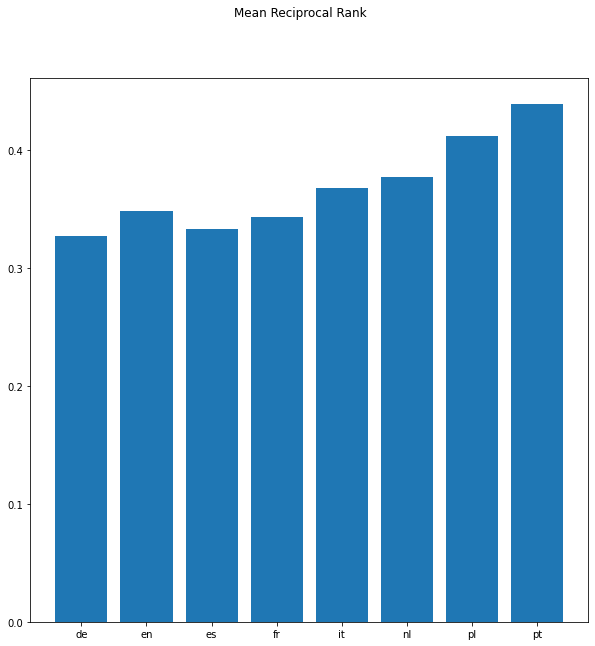

Topics similar to 'en' text: Rules of the Advisory Committee on Vocational Training



["'Richtlijn 64/225/EEG van de Raad van 25 februari 1964 ter opheffing van de beperkingen van de vrijheid van vestiging en van het vrij verrichten van diensten",
 "'63/688/CEE: Estatuto do Comité consultivo para a formação profissional'",
 "'Verordnung (EWG) Nr. 1612/68 des Rates vom 15. Oktober 1968 über die Freizügigkeit der Arbeitnehmer innerhalb der Gemeinschaft'",
 '"Regolamento (CEE) n. 1017/68 del Consiglio',
 '"Règlement (CEE) n° 2603/69 du Conseil',
 "'JRC-ACQUIS 31968R0259 Polish'",
 "'Regulamento (CEE",
 "'EGA Raad: Statuten van het Voorzieningsagentschap van Euratom'",
 "'Richtlijn 64/221/EEG van de Raad van 25 februari 1964 voor de coördinatie van de voor vreemdelingen geldende bijzondere maatregelen ten aanzien van verplaatsing en verblijf",
 "'Regulamento (CEE) nº 1017/68 do Conselho",
 "'Directiva 67/548/CEE do Conselho",
 '"Directive 64/432/CEE du Conseil',
 "'Regulation No 7/63/Euratom of the Council of 3 December 1963 on rules of procedure of the Arbitration Committe

In [71]:
#for english sentence
find_dif('Rules of the Advisory Committee on Vocational Training', 20, 'en')

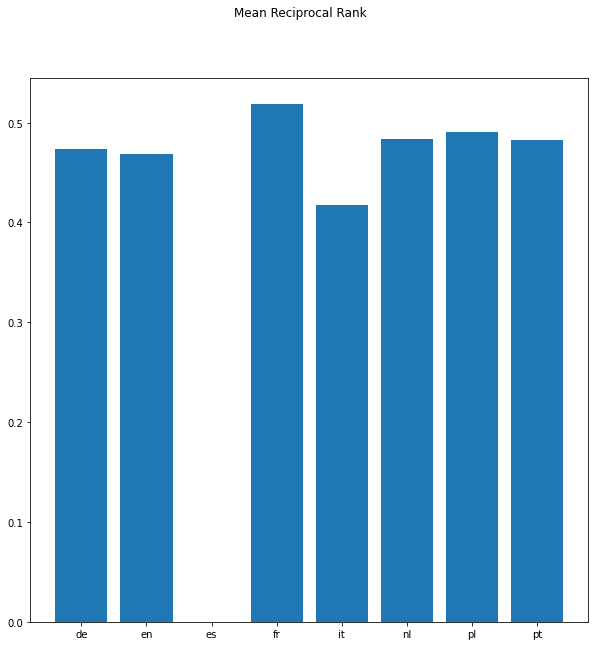

Topics similar to 'fr' text: d'une réglementation d'ensemble uniforme. Pour le Comité économique et social



["'JRC-ACQUIS 31962L2005 Polish'",
 "'Richtlinie 64/225/EWG des Rates vom 25. Februar 1964 zur Aufhebung der Beschränkungen der Niederlassungsfreiheit und des freien Dienstleistungsverkehrs auf dem Gebiet der Rückversicherung und Retrozession'",
 "'Richtlinie 69/464/EWG des Rates vom 8. Dezember 1969 zur Bekämpfung des Kartoffelkrebses'",
 "'Directiva 70/373/CEE do Conselho",
 "'Direttiva 64/225/CEE del Consiglio del 25 febbraio 1964",
 "'Richtlinie 66/401/EWG des Rates vom 14. Juni 1966 über den Verkehr mit Futterpflanzensaatgut  /* KODIFIZERTE FASSUNG CF 374Y0608(02) */'",
 "'Richtlijn 64/221/EEG van de Raad van 25 februari 1964 voor de coördinatie van de voor vreemdelingen geldende bijzondere maatregelen ten aanzien van verplaatsing en verblijf",
 "'JRC-ACQUIS 31970L0157 Polish'",
 "'Council Directive 69/493/EEC of 15 December 1969 on the approximation of the laws of the Member States relating to crystal glass'",
 "'Directive 69/63/CEE du Conseil",
 '"63/266/CEE: Décision du Conseil

In [63]:
#for french sentence
find_dif("d'une réglementation d'ensemble uniforme. Pour le Comité économique et social", 20, 'fr')

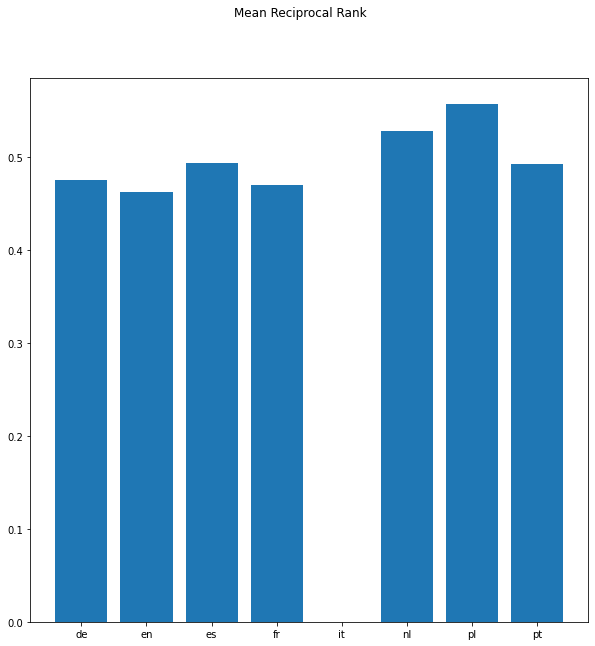

Topics similar to 'pt' text: após parecer da Comissão Paritária e tomando em consideração a competência



["'Règlement (CEE) n° 1017/68 du Conseil",
 "'Reglamento nº 6/66/Euratom",
 "'Council Directive 68/297/EEC of 19 July 1968 on the standardisation of provisions regarding the duty-free admission of fuel contained in the fuel tanks of commercial motor vehicles'",
 "'Richtlinie 69/464/EWG des Rates vom 8. Dezember 1969 zur Bekämpfung des Kartoffelkrebses'",
 "'Directiva 63/474/CEE do Conselho",
 "'Verordening (EEG) nr. 1017/68 van de Raad van 19 juli 1968 houdende de toepassing van mededingingsregels op het gebied van het vervoer per spoor",
 "'Directiva 70/524/CEE do Conselho",
 "'Richtlinie 66/402/EWG des Rates vom 14. Juni 1966 über den Verkehr mit Getreidesaatgut  /* KODIFIZERTE FASSUNG CF 374Y0608(03) */'",
 "'EEC: Council Directive on the approximation of the rules of the Member States concerning the colouring matters authorized for use in foodstuffs intended for human consumption'",
 "'Directiva 69/493/CEE do Conselho",
 "'Richtlijn 64/432/EEG van de Raad van 26 juni 1964 inzake ve

In [67]:
#for portuguese sentence
find_dif('após parecer da Comissão Paritária e tomando em consideração a competência', 20, 'pt')

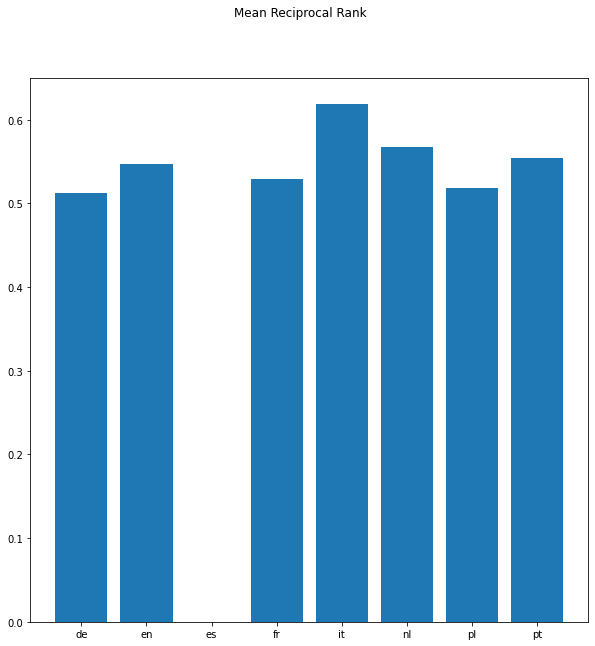

Topics similar to 'it' text: SU PROPOSTA DELLA COMMISSIONE



['"Regolamento n. 136/66/CEE del Consiglio',
 '"Règlement n° 79/65/CEE du Conseil',
 "'Verordnung Nr. 1043/67/EWG der Kommission vom 22. Dezember 1967 über die Durchführungsbestimmungen zur Festsetzung der Grundquoten für Zucker'",
 "'63/688/EEG: Statuut van het Raadgevend Comité voor de beroepsopleiding'",
 "'Verordnung (EWG) Nr. 821/68 der Kommission vom 28. Juni 1968 über die bei der Gewährung der Erstattung bei der Ausfuhr geltende Definition der geschälten und geschliffenen Getreidekörner und der perlförmig geschliffenen Getreidekörner'",
 "'Regulation (EEC) No 537/70 of the Commission of 23 March 1970 authorising Member States to take measures derogating from certain requirements of the quality standards applicable to exports to third countries of flowering bulbs",
 "'70/244/ECSC",
 "'Council Directive 68/414/EEC of 20 December 1968 imposing an obligation on Member States of the EEC to maintain minimum stocks of crude oil and/or petroleum products'",
 "'Richtlinie 70/50/EWG der K

In [65]:
#for italian sentence
find_dif('SU PROPOSTA DELLA COMMISSIONE', 20, 'it')

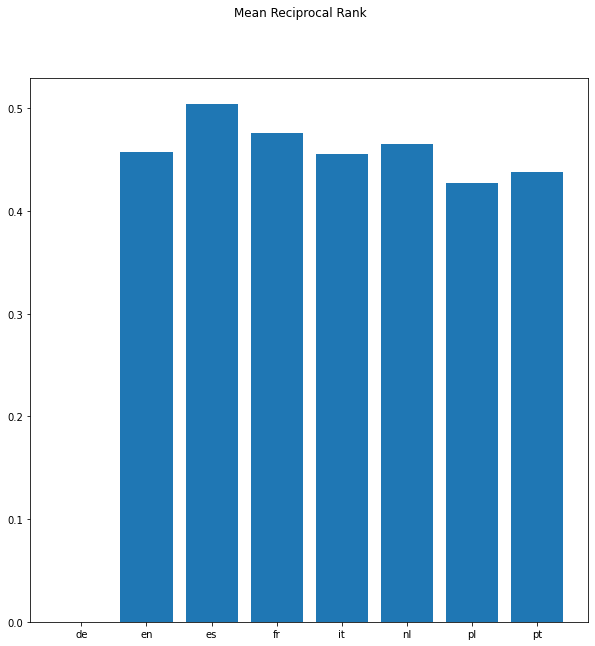

Topics similar to 'es' text:  visto el Reglamento n º 15 del Consejo



["'63/688/CEE: Statut du comité consultatif pour la formation professionnelle'",
 '"Règlement n° 136/66/CEE du Conseil',
 "'Regulation (EEC) No 234/68 of the Council of 27 February 1968 on the establishment of a common organisation of the market in live trees and other plants",
 '"Directive 64/433/CEE du Conseil',
 "'63/688/CEE: Estatuto del Comité consultivo de formación profesional'",
 '"Directive 64/225/CEE du Conseil',
 '"Règlement (CEE) n° 821/68 de la Commission',
 "'Règlement n° 741/67/CEE du Conseil",
 "'Reglamento (CEE) nº 1017/68 del Consejo",
 '"Directive 64/221/CEE du Conseil',
 "'Reglamento nº 422/67/CEE",
 "'Directiva 64/221/CEE del Consejo",
 "'Reglamento (CEE) nº 1107/70 del Consejo",
 "'CEE Conseil: Règlement n° 25 relatif au financement de la politique agricole commune'",
 "'JRC-ACQUIS 31969R1192 Polish'",
 "'Regulation (EEC) No 1192/69 of the Council of 26 June 1969 on common rules for the normalisation of the accounts of railway undertakings'",
 "'Reglamento (CEE) n

In [64]:
#for spanish sentence
find_dif(' visto el Reglamento n º 15 del Consejo', 20, 'es')

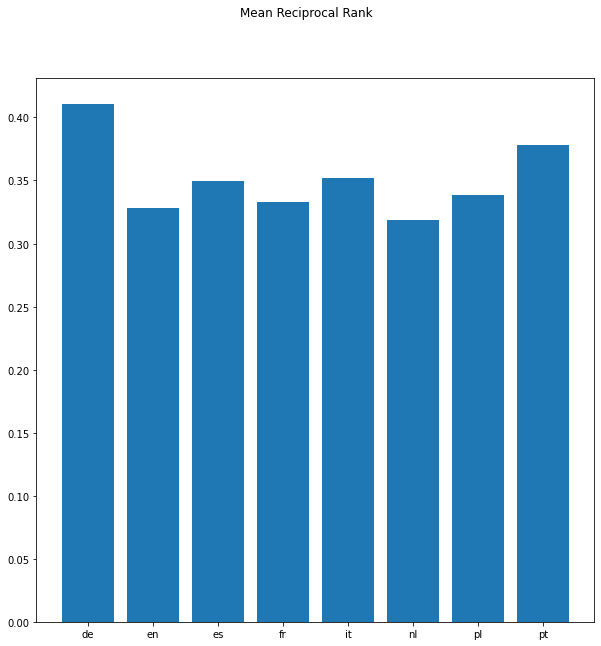

Topics similar to 'de' text:  Die zum Zeitpunkt des Inkrafttretens dieser Verordnung geltenden Geschäftsordnungen des Beratenden Ausschusses und des Fachausschusses werden weiter angewandt.



["'63/32/EWG: Beschluß des Rats vom 18. Dezember 1962 zur Bestimmung der Anstellungsbehörde für den Kontrollausschuß'",
 "'Verordnung (EWG) Nr. 1431/68 der Kommission vom 13. September 1968 zur Ergänzung der Verordnung Nr. 1043/67/EWG durch die Definition des Begriffs des Zucker erzeugenden Unternehmens'",
 "'Verordnung (EWG) Nr. 1265/69 der Kommission vom 1. Juli 1969 über die Methoden zur Bestimmung der Qualität von Zucker",
 '"Regolamento (CEE) n. 234/68 del Consiglio',
 "'Verordening (EEG) nr. 1192/69 van de Raad van 26 juni 1969 betreffende de gemeenschappelijke regels voor de normalisatie van de rekeningstelsels van de spoorwegondernemingen'",
 "'63/688/CEE: Estatuto do Comité consultivo para a formação profissional'",
 "'JRC-ACQUIS 31962D1217(02) Polish'",
 "'Verordnung (EWG) Nr. 1612/68 des Rates vom 15. Oktober 1968 über die Freizügigkeit der Arbeitnehmer innerhalb der Gemeinschaft'",
 "'Regulamento (CEE) nº 1192/69 do Conselho",
 "'JRC-ACQUIS 31970R1108 Polish'",
 '"Directive

In [72]:
#for german sentence
find_dif(' Die zum Zeitpunkt des Inkrafttretens dieser Verordnung geltenden Geschäftsordnungen des Beratenden Ausschusses und des Fachausschusses werden weiter angewandt.', 20, 'de')

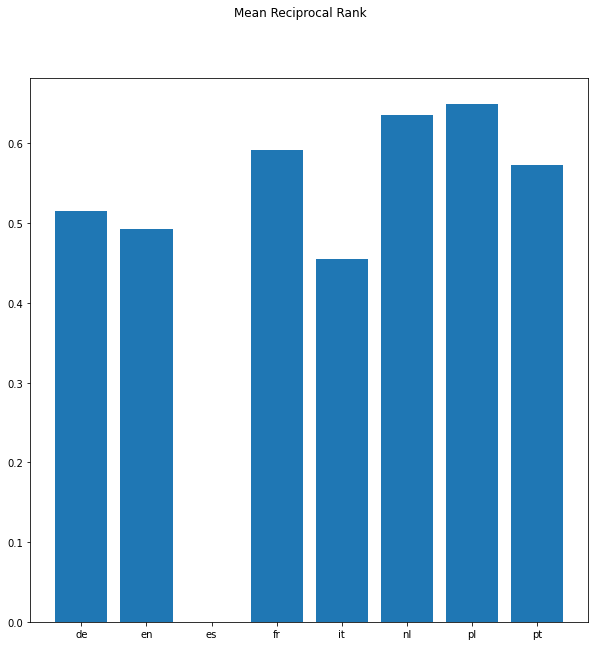

Topics similar to 'pl' text: po zasięgnięciu opinii Wspólnego Komitetu



["'JRC-ACQUIS 31968R0259 Polish'",
 "'JRC-ACQUIS 31962R0017 Polish'",
 "'JRC-ACQUIS 31967L0227 Polish'",
 "'JRC-ACQUIS 31964L0433 Polish'",
 "'Richtlijn 64/433/EEG van de Raad van 26 juni 1964 inzake gezondheidsvraagstukken op het gebied van het intracommunautaire handelsverkeer in vers vlees  /* GECODIFICEERDE VERSIE CF 375Y0820(02) */'",
 "'56/399/EEG: Besluit van de Raad van 14 juni 1966 houdende de instelling van een permanent comité voor teeltmateriaal voor land-",
 "'Regulation No 7/63/Euratom of the Council of 3 December 1963 on rules of procedure of the Arbitration Committee provided for in Article 18 of the Treaty establishing the European Atomic Energy Community'",
 "'Verordnung (EWG) Nr. 1017/68 des Rates vom 19. Juli 1968 über die Anwendung von Wettbewerbsregeln auf dem Gebiet des Eisenbahn-",
 "'JRC-ACQUIS 31969L0063 Polish'",
 "'JRC-ACQUIS 31963D0266 Polish'",
 '"Direttiva 64/221/CEE del Consiglio del 25 febbraio 1964 per il coordinamento dei provvedimenti speciali riguar

In [75]:
#for polish sentence
find_dif('po zasięgnięciu opinii Wspólnego Komitetu', 20, 'pl')

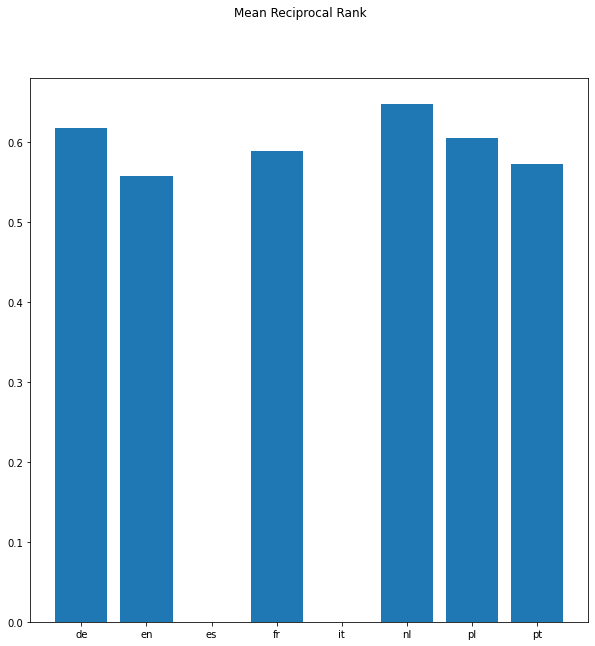

Topics similar to 'nl' text: Voorzitter van het Economisch en Sociaal Comité



["'EEC: First Council Directive on the establishment of certain common rules for international transport (carrying of goods by road for hire or reward)'",
 "'63/266/EEC: Council Decision of 2 April 1963 laying down general principles for implementing a common vocational training policy'",
 "'Richtlinie 69/464/EWG des Rates vom 8. Dezember 1969 zur Bekämpfung des Kartoffelkrebses'",
 "'Directiva 64/432/CEE do Conselho",
 "'Règlement (CEE) n° 1017/68 du Conseil",
 "'Regulation No 79/65/EEC of the Council of 15 June 1965 setting up a network for the collection of accountancy data on the incomes and business operation of agricultural holdings in the European Economic Community'",
 "'EAEC Council: Directive on freedom to take skilled employment in the field of nuclear energy'",
 '"Directive 67/653/CEE du Conseil',
 "'Council Directive 68/221/EEC of 30 April 1968 on a common method for calculating the average rates provided for in Article 97 of the Treaty'",
 "'Erste Richtlinie 67/227/EWG de

In [83]:
#for dutch sentence
find_dif("Voorzitter van het Economisch en Sociaal Comité", 20, 'nl')

### Find topics from same language

In [99]:
#function which finds relevant topics from the same language

def find_same(query, number, index_language):
  
  query_embed = embed_text(query)
  query_embedding = embed_text(query)[0]
  search_results_text = language_name_to_index_text[index_language].nearest(query_embedding, n=number)
  search_results_title = language_name_to_index[index_language].nearest(query_embedding, n=number)
  search_results = search_results_title + search_results_text
  
  result_list =[]
  for result in search_results:
    row = split_df.loc[split_df['text'] == result]
    for index, row_iter in row.iterrows():
      result_list.append(row_iter['title'])
  result_list = r.sample(list(dict.fromkeys(result_list)),number)

  return result_list

In [98]:
#for english sentence
find_same('Rules of the Advisory Committee on Vocational Training', 20, 'en')

["'Council Directive 66/402/EEC of 14 June 1966 on the marketing of cereal seed  /* CODIFIED VERSION CF 374Y0608(03) */'",
 "'Regulation No 7/63/Euratom of the Council of 3 December 1963 on rules of procedure of the Arbitration Committee provided for in Article 18 of the Treaty establishing the European Atomic Energy Community'",
 "'Regulation No 136/66/EEC of the Council of 22 September 1966 on the establishment of a common organisation of the market in oils and fats'",
 "'Regulation No 423/67/EEC",
 "'Council Directive 68/221/EEC of 30 April 1968 on a common method for calculating the average rates provided for in Article 97 of the Treaty'",
 "'EEC Council: Regulation No 17: First Regulation implementing Articles 85 and 86 of the Treaty'",
 "'Council Directive 68/297/EEC of 19 July 1968 on the standardisation of provisions regarding the duty-free admission of fuel contained in the fuel tanks of commercial motor vehicles'",
 "'EEC: Council Directive on the approximation of the rules o

In [100]:
#for french sentence
find_same("d'une réglementation d'ensemble uniforme. Pour le Comité économique et social", 20, 'fr')

['"Directive 65/469/CEE du Conseil',
 "'Erste Richtlinie 68/151/EWG des Rates vom 9. März 1968 zur Koordinierung der Schutzbestimmungen",
 "'Règlement (CEE) n° 1017/68 du Conseil",
 '"Directive 64/432/CEE du Conseil',
 '"Règlement (CEE) n° 1191/69 du Conseil',
 '"Règlement n° 136/66/CEE du Conseil',
 '"Règlement (CEE) n° 2146/68 du Conseil',
 '"Prima direttiva 68/151/CEE del Consiglio',
 "'Règlement (CEE) n° 1192/69 du Conseil",
 '"68/416/CEE: Décision du Conseil',
 "'Règlement n° 741/67/CEE du Conseil",
 '"Règlement n° 19/65/CEE du Conseil',
 '"Directive 68/221/CEE du Conseil',
 "'Directive 69/464/CEE du Conseil",
 "'Directive 63/474/CEE du Conseil",
 '"Règlement (CEE) n° 234/68 du Conseil',
 '"Directive 70/358/CEE du Conseil',
 "'Directive 69/63/CEE du Conseil",
 "'Directive 69/335/CEE du Conseil",
 '"Directive 64/225/CEE du Conseil']

In [101]:
#for portuguese sentence
find_same('após parecer da Comissão Paritária e tomando em consideração a competência', 20, 'pt')

["'Regulamento (CEE) nº 1192/69 do Conselho",
 "'Directiva 70/156/CEE do Conselho",
 "'Directiva 70/221/CEE do Conselho",
 "'Regulamento (CEE) nº 1191/69 do Conselho",
 "'Directiva 67/548/CEE do Conselho",
 "'Regulamento (CEE) nº 1467/70 do Conselho",
 "'63/688/CEE: Estatuto do Comité consultivo para a formação profissional'",
 "'Decisão do Conselho",
 "'Regulamento (CEE) nº 234/68 do Conselho",
 "'Regulamento (CEE) nº 827/68 do Conselho",
 "'Directiva 70/388/CEE do Conselho",
 "'Directiva 69/169/CEE do Co nselho",
 "'Directiva 70/373/CEE do Conselho",
 "'64/350/CEE: Decisão do Conselho",
 "'Directiva 66/402/CEE do Conselho",
 "'Regulamento (CEE) nº 2602/69 do Conselho",
 "'63/266/CEE: Decisão do Conselho",
 "'Regulamento nº 49 do Conselho que altera a data de aplicação de determinados actos relativos à política agrícola comum'",
 "'Directiva 70/387/CEE do Conselho",
 "'Regulamento nº 19/65/CEE do Conselho"]

In [102]:
#for italian sentence
find_same('SU PROPOSTA DELLA COMMISSIONE', 20, 'it')

['"Regolamento n. 474/67/CEE della Commissione',
 '"Direttiva 64/221/CEE del Consiglio del 25 febbraio 1964 per il coordinamento dei provvedimenti speciali riguardanti il trasferimento e il soggiorno degli stranieri',
 '"Decisione relativa all\'istituzione della «Gazzetta Ufficiale delle Comunità europee»"',
 '"Regolamento n. 6/66/Euratom',
 "'Regolamento (CEE) n. 2264/69 della Commissione",
 '"Direttiva 64/475/CEE del Consiglio',
 '"Regolamento n. 136/66/CEE del Consiglio',
 "'Direttiva 64/432/CEE del Consiglio",
 "'Regolamento (CEE) n. 316/68 del Consiglio",
 "'Regolamento (CEE) n. 315/68 del Consiglio",
 '"Direttiva 67/653/CEE del Consiglio',
 '"Direttiva 68/360/CEE del Consiglio',
 '"DECISIONE relativa all\'istituzione della «Gazzetta Ufficiale delle Comunità Europee»"',
 '"CEE Consiglio: Regolamento n. 26 relativo all\'applicazione di alcune regole di concorrenza alla produzione e al commercio dei prodotti agricoli"',
 "'63/688/CEE: Statuto del Comitato consultivo per la formazion

In [103]:
#for spanish sentence
find_same(' visto el Reglamento n º 15 del Consejo', 20, 'es')

["'Reglamento (CEE) nº 1017/68 del Consejo",
 "'Reglamento (CEE) nº 1467/70 del Consejo",
 "'Primera Directiva del Consejo",
 "'Directiva 67/653/CEE del Consejo",
 "'66/399/CEE: Decisión del Consejo",
 "'Reglamento (CEE) nº 234/68 del Consejo",
 "'Reglamento n° 19/65/CEE del Consejo",
 "'Directiva 69/335/CEE del Consejo",
 "'Directiva 70/220/CEE del Consejo",
 "'Directiva 68/221/CEE del Consejo",
 "'Directiva 69/63/CEE del Consejo",
 "'Directiva 68/89/CEE del Consejo",
 "'Reglamento nº 7/63/Euratom del Consejo",
 "'Reglamento nº3 relativo a la aplicación del artículo 24 del Tratado constitutivo de la Comunidad Europea de la Energía Atómica'",
 "'Reglamento (Euratom",
 "'Reglamento (CEE) n° 1253/70 del Consejo",
 "'Reglamento (CEE) n° 448/69 del Consejo",
 "'Directiva 65/469/CEE del Consejo",
 "'Directiva 64/433/CEE del Consejo",
 "'Reglamento (CEE) n° 2146/68 del Consejo"]

In [104]:
#for german sentence
find_same(' Die zum Zeitpunkt des Inkrafttretens dieser Verordnung geltenden Geschäftsordnungen des Beratenden Ausschusses und des Fachausschusses werden weiter angewandt.', 20, 'de')

["'Verordnung (EWG) Nr. 827/68 des Rates vom 28. Juni 1968 über die gemeinsame Marktorganisation für bestimmte in Anhang II des Vertrages aufgeführte Erzeugnisse'",
 "'Verordnung Nr. 7/63/Euratom des Rats vom 3. Dezember 1963 über die Geschäftsordnung des in Artikel 18 des Vertrages zur Gründung der Europäischen Atomgemeinschaft vorgesehenen Schiedsausschusses'",
 "'Verordnung (EWG) Nr. 1191/69 des Rates vom 26. Juni 1969 über das Vorgehen der Mitgliedstaaten bei mit dem Begriff des öffentlichen Dienstes verbundenen Verpflichtungen auf dem Gebiet des Eisenbahn-",
 "'Verordnung (EWG) Nr. 1017/68 des Rates vom 19. Juli 1968 über die Anwendung von Wettbewerbsregeln auf dem Gebiet des Eisenbahn-",
 "'Verordnung (EWG) Nr. 1192/69 des Rates vom 26. Juni 1969 über gemeinsame Regeln für die Normalisierung der Konten der Eisenbahnunternehmen'",
 "'63/688/EWG: Satzung des Beratenden Ausschusses für die Berufsausbildung'",
 "'EAG Rat: Richtlinie über den freien Zugang zu qualifizierten Beschäftig

In [105]:
#for polish sentence
find_same('po zasięgnięciu opinii Wspólnego Komitetu', 20, 'pl')

["'JRC-ACQUIS 31969L0464 Polish'",
 "'JRC-ACQUIS 31968R1017 Polish'",
 "'JRC-ACQUIS 31963R0007 Polish'",
 "'JRC-ACQUIS 31970L0157 Polish'",
 "'JRC-ACQUIS 31962L2005 Polish'",
 "'JRC-ACQUIS 31963D0266 Polish'",
 "'JRC-ACQUIS 31958R0003(01) Polish'",
 "'JRC-ACQUIS 31962R0017 Polish'",
 "'JRC-ACQUIS 31964L0433 Polish'",
 "'JRC-ACQUIS 31969L0493 Polish'",
 "'JRC-ACQUIS 31965R0019 Polish'",
 "'JRC-ACQUIS 31966L0402 Polish'",
 "'JRC-ACQUIS 31963D0032 Polish'",
 "'JRC-ACQUIS 31966L0601 Polish'",
 "'JRC-ACQUIS 31967L0653 Polish'",
 "'JRC-ACQUIS 31968L0089 Polish'",
 "'JRC-ACQUIS 31962L2645 Polish'",
 "'JRC-ACQUIS 31962L0302 Polish'",
 "'JRC-ACQUIS 31965L0469 Polish'",
 "'JRC-ACQUIS 31967L0227 Polish'"]

In [106]:
#for dutch sentence
find_same("Voorzitter van het Economisch en Sociaal Comité", 20, 'nl')

["'Richtlijn 64/432/EEG van de Raad van 26 juni 1964 inzake veterinairrechtelijke vraagstukken op het gebied van het intracommunautaire handelsverkeer in runderen en varkens  /* GECODIFICEERDE VERSIE CF 375Y0820(01) */'",
 "'68/416/EEG: Beschikking van de Raad van 20 december 1968 betreffende het sluiten en uitvoeren van de speciale intergouvernementele overeenkomsten inzake de verplichting voor de Lid-Staten om minimumvoorraden ruwe aardolie en/of aardolieprodukten in opslag te houden'",
 "'Richtlijn 64/225/EEG van de Raad van 25 februari 1964 ter opheffing van de beperkingen van de vrijheid van vestiging en van het vrij verrichten van diensten",
 "'Verordening nr. 423/67/EEG",
 "'Richtlijn 68/414/EEG van de Raad van 20 december 1968 houdende verplichting voor de Lid-Staten van de E.E.G. om minimumvoorraden ruwe aardolie en/of aardolieprodukten in opslag te houden'",
 "'Verordening (EEG) nr. 1108/70 van de Raad van 4 juni 1970 betreffende de invoering van een boekhouding van de uitgav